<a href="https://colab.research.google.com/github/josephmargaryan/Biomedical-Image-Segmentation/blob/main/ISIC_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the Kaggle library
!pip install kaggle

# Upload your Kaggle API key file if you haven't already (this will prompt you to choose a file from your local machine)
from google.colab import files
files.upload()

# Move the API key into the correct folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permissions (to avoid a warning on Kaggle tool startup)
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
# Download the data from Kaggle
!kaggle competitions download -c isic-2024-challenge

# Unzip the downloaded files (adjust the path and filenames as per your downloaded data structure)
!unzip -q isic-2024-challenge.zip -d isic-2024-challenge

# List the contents of the directory to verify the data is downloaded
!ls isic-2024-challenge

100% 1.99G/2.00G [00:09<00:00, 247MB/s]
100% 2.00G/2.00G [00:09<00:00, 224MB/s]
sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


In [6]:
# Download the dataset
!kaggle datasets download -d andrewmvd/isic-2019

# Unzip the downloaded dataset
!unzip -q isic-2019.zip -d ./isic-2019

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/isic-2019
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 9.07G/9.10G [01:16<00:00, 156MB/s]
100% 9.10G/9.10G [01:16<00:00, 128MB/s]


In [7]:
# Download the dataset
!kaggle datasets download -d nischaydnk/isic-2020-jpg-224x224-resized

# Unzip the downloaded dataset
!unzip -q isic-2020-jpg-224x224-resized.zip -d ./isic-2020-jpg-224x224-resized

Dataset URL: https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-224x224-resized
License(s): CC0-1.0
 97% 457M/473M [00:02<00:00, 197MB/s]
100% 473M/473M [00:02<00:00, 188MB/s]


In [3]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torch.utils.data import Sampler
import math
from math import ceil
import torch.nn.functional as F
from collections import defaultdict
import os
import h5py
import io
from PIL import Image

In [8]:
images_2019 = sorted(glob("/content/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/*.jpg"))
labels_2019 = pd.read_csv("/content/isic-2019/ISIC_2019_Training_GroundTruth.csv")

# Define benign and malignant categories
benign_labels = ['NV', 'BKL', 'DF', 'VASC']
malignant_labels = ['MEL', 'BCC', 'AK', 'SCC']

# Initialize the targets column with zeros
labels_2019['targets'] = 0

# Set targets to 1 for malignant cases
labels_2019.loc[labels_2019[malignant_labels].sum(axis=1) > 0, 'targets'] = 1

# Select only the necessary columns
labels_2019 = labels_2019[['image', 'targets']]

df_2019 = pd.DataFrame({'image_paths': images_2019, 'targets': labels_2019['targets']})

# Only get targets == 1
df_2019 = df_2019[df_2019['targets'] == 1]
print(df_2019.head())

                                          image_paths  targets
2   /content/isic-2019/ISIC_2019_Training_Input/IS...        1
4   /content/isic-2019/ISIC_2019_Training_Input/IS...        1
12  /content/isic-2019/ISIC_2019_Training_Input/IS...        1
21  /content/isic-2019/ISIC_2019_Training_Input/IS...        1
25  /content/isic-2019/ISIC_2019_Training_Input/IS...        1


In [9]:
# Load image paths using glob and ensure sorted order
image_paths_2020 = sorted(glob("/content/isic-2020-jpg-224x224-resized/train-image/image/*.jpg"))

# Load metadata
metadata_2020 = "/content/isic-2020-jpg-224x224-resized/train-metadata.csv"
metadata_2020_df = pd.read_csv(metadata_2020)

# Extract isic_id from image filenames
image_ids = [os.path.basename(path).split('.')[0] for path in image_paths_2020]

# Filter metadata to include only those with matching isic_id
filtered_metadata = metadata_2020_df[metadata_2020_df['isic_id'].isin(image_ids)]

# Ensure image paths and metadata align
aligned_image_paths = []
aligned_targets = []

for img_id in image_ids:
    if img_id in filtered_metadata['isic_id'].values:
        aligned_image_paths.append(image_paths_2020[image_ids.index(img_id)])
        aligned_targets.append(filtered_metadata[filtered_metadata['isic_id'] == img_id]['target'].values[0])

# Create DataFrame with filtered image paths, isic_id, and targets
df_2020 = pd.DataFrame({
    'image_paths': aligned_image_paths,
    'isic_id': image_ids[:len(aligned_image_paths)],  # Ensure alignment
    'targets': aligned_targets
})

# Sort by 'isic_id' and 'target' if needed
df_2020 = df_2020.sort_values(by=['isic_id', 'targets'])
df_2020 = df_2020.drop(columns=['isic_id'], axis=1)

df_2020 = df_2020[df_2020['targets'] == 1]

# Display the DataFrame
print(df_2020.head())

                                           image_paths  targets
90   /content/isic-2020-jpg-224x224-resized/train-i...        1
234  /content/isic-2020-jpg-224x224-resized/train-i...        1
313  /content/isic-2020-jpg-224x224-resized/train-i...        1
398  /content/isic-2020-jpg-224x224-resized/train-i...        1
458  /content/isic-2020-jpg-224x224-resized/train-i...        1


In [10]:
metadata = pd.read_csv('/content/isic-2024-challenge/train-metadata.csv', low_memory=False)
isic_ids = metadata['isic_id'].values
targets = metadata['target'].values

# Initialize lists to store image paths and targets
image_paths = []
all_targets = []

# Open the HDF5 file
with h5py.File('/content/isic-2024-challenge/train-image.hdf5', 'r') as fp_hdf:
    for isic_id, target in zip(isic_ids, targets):
        image_data = fp_hdf[isic_id][()]

        # Save the image data as JPEG file
        image_path = f"/tmp/{isic_id}.jpg"
        with open(image_path, 'wb') as f:
            f.write(image_data)

        # Append the image path and target to lists
        image_paths.append(image_path)
        all_targets.append(target)

# Create a DataFrame with image paths and targets
df_2024 = pd.DataFrame({'image_paths': image_paths, 'targets': all_targets})
print(df_2024.head())

             image_paths  targets
0  /tmp/ISIC_0015670.jpg        0
1  /tmp/ISIC_0015845.jpg        0
2  /tmp/ISIC_0015864.jpg        0
3  /tmp/ISIC_0015902.jpg        0
4  /tmp/ISIC_0024200.jpg        0


In [12]:
merged_df = pd.concat((df_2024, df_2020, df_2019), axis=0).reset_index(drop=True)
merged_df

,image_paths,targets
0,/tmp/ISIC_0015670.jpg,0
1,/tmp/ISIC_0015845.jpg,0
2,/tmp/ISIC_0015864.jpg,0
3,/tmp/ISIC_0015902.jpg,0
4,/tmp/ISIC_0024200.jpg,0
...,...,...
410978,/content/isic-2019/ISIC_2019_Training_Input/IS...,1
410979,/content/isic-2019/ISIC_2019_Training_Input/IS...,1
410980,/content/isic-2019/ISIC_2019_Training_Input/IS...,1
410981,/content/isic-2019/ISIC_2019_Training_Input/IS...,1


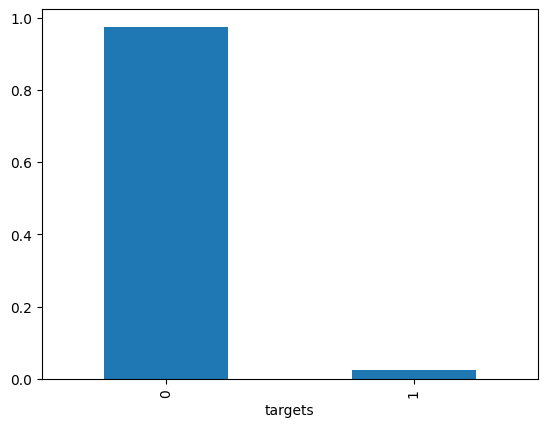

targets
0    400666
1     10317
Name: count, dtype: int64

In [13]:
merged_df['targets'].value_counts(normalize=True).plot(kind='bar')
plt.show()
merged_df['targets'].value_counts()

In [20]:
"""
        v2.RandomHorizontalFlip(),
        v2.RandomPerspective(),
        v2.RandomRotation((-45, 45)),
        v2.RandomVerticalFlip(),
        v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        v2.ElasticTransform(alpha=250.0),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        v2.RandomAutocontrast(),
        v2.RandomEqualize(),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        v2.ColorJitter(brightness=.5, hue=.3),
"""

transform = v2.Compose([
        v2.Resize((380, 380)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])

    ])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_paths']
        target = torch.tensor(self.dataframe.iloc[idx]['targets'], dtype=torch.float32)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, target


dataset = ImageDataset(merged_df, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader with custom sampler
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)


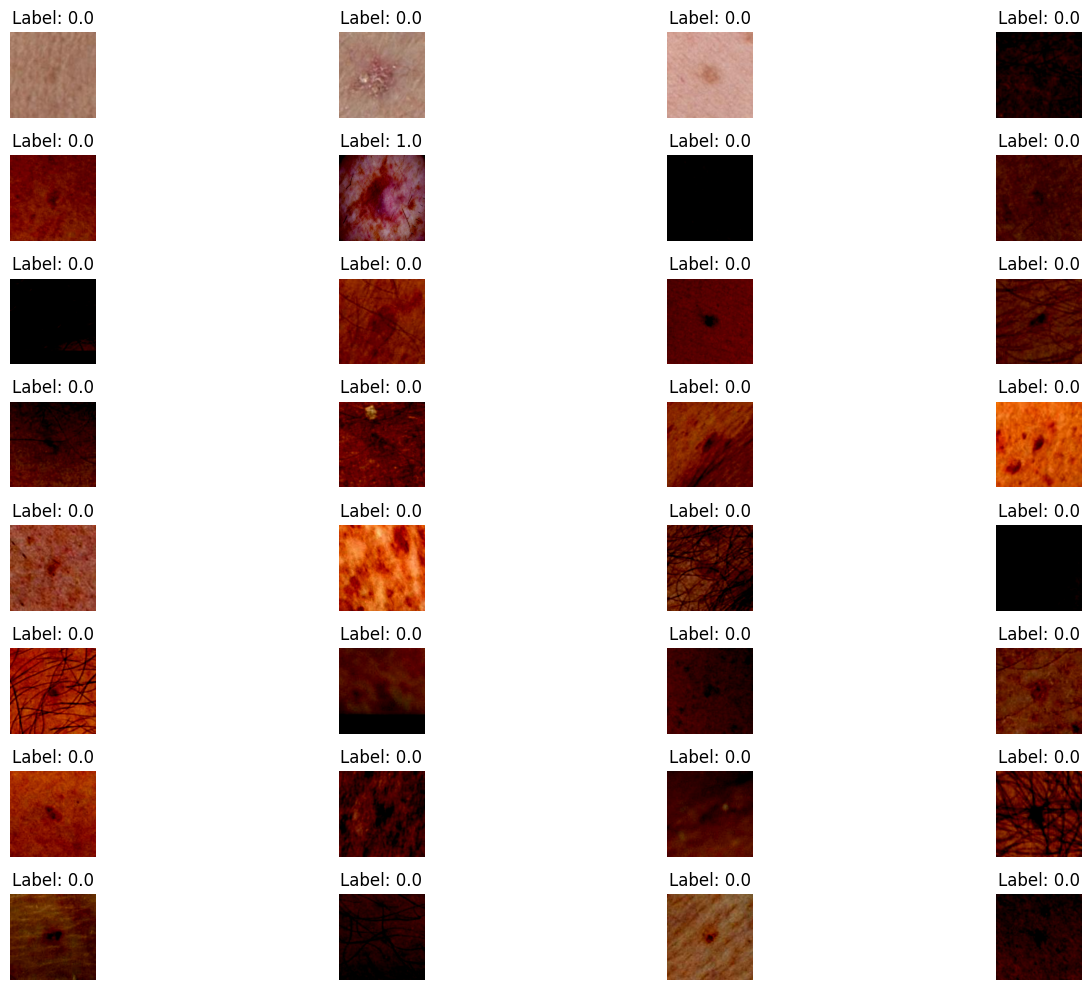

In [21]:
def unnormalize(img_tensor, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]):
    """
    Unnormalize a tensor image with mean and standard deviation.

    Args:
    - img_tensor (Tensor): Input image tensor of shape (C, H, W) or (B, C, H, W).
    - mean (list): Mean values for each channel.
    - std (list): Standard deviation values for each channel.

    Returns:
    - Tensor: Unnormalized image tensor.
    """
    mean = np.array(mean)
    std = np.array(std)
    img_tensor = img_tensor.clone()  # Avoid modifying the original tensor

    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # Unnormalize

    return img_tensor

# Obtain a batch of images and their labels from the train_loader
images, labels = next(iter(train_loader))

# Check if images are grayscale or RGB
num_channels = images.shape[1]

# Set appropriate mean and std based on the number of channels
if num_channels == 1:
    mean = [0.5]
    std = [0.5]
else:
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

# Unnormalize the images
images = unnormalize(images)

# Clip image values to [0, 1] range
images = np.clip(images.numpy(), 0, 1)
images = torch.tensor(images, dtype=torch.float32)

# Plot each image in the batch in a 6x3 grid along with its label
batch_size = images.shape[0]
fig, axes = plt.subplots(8, 4, figsize=(15, 10))

for i in range(batch_size):
    row = i // 4
    col = i % 4
    image = images[i, :, :, :].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

    # Handle plotting for grayscale images
    if num_channels == 1:
        axes[row, col].imshow(image[:, :, 0], cmap='gray')
    else:
        axes[row, col].imshow(image)

    axes[row, col].axis('off')  # Hide the axes
    axes[row, col].set_title(f'Label: {labels[i].item()}', fontsize=12)  # Set the title to the label

plt.tight_layout()
plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [22]:
# EfficientNet model configuration
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
               '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
               ', ' + 'eps=' + str(self.eps) + ')'

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()  # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = survival_prob
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)

        self.conv = nn.Sequential(
            CNNBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs
        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.features = self.create_features(width_factor, depth_factor, last_channels)

        # Replace GeM with Global Average Pooling
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Adding the modified classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(last_channels, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # Assuming binary classification, use nn.Softmax(dim=1) for multi-class
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha**phi
        width_factor = beta**phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels, out_channels, expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size, padding=kernel_size // 2
                    )
                )
                in_channels = out_channels

        features.append(CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0))
        return nn.Sequential(*features)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x.view(x.shape[0], -1))

In [24]:
def train(model,
          num_epochs,
          train_loader,
          val_loader,
          lr=1e-4,
          weight_decay=1e-5,
          patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()
    train_losses = []
    val_losses = []
    counter = 0
    best_model_state = None
    best_val_loss = float('inf')
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                           T_max=20,
                                                           eta_min=1e-6,
                                                           last_epoch=-1
                                                           )

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = []
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y.view(-1, 1))
            loss.backward()
            optimizer.step()
            avg_train_loss.append(loss.item())
        avg_train_loss = np.mean(avg_train_loss)

        model.eval()
        avg_val_loss = []
        for j, (x, y) in enumerate(tqdm(val_loader)):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output = model(x)
                loss = criterion(output, y.view(-1, 1))
                avg_val_loss.append(loss.item())
        avg_val_loss = np.mean(avg_val_loss)

        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

        tqdm.write(f"Epoch {epoch+1}\nval loss {avg_val_loss}")

        scheduler.step()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    df = pd.DataFrame({'train': train_losses, 'val': val_losses})
    plt.plot(df.index+1, df['train'], label='train loss')
    plt.plot(df.index+1, df['val'], label='val loss', linestyle='-.', marker="D")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss over epoch')
    plt.grid(visible=True)
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), 'efficientNetB4.pth')
    return model, best_val_loss

In [25]:
model = EfficientNet("b4", 1).to(device)
image_data = torch.randn(2, 3, 380, 380).to(device)
output = model(image_data)
print(output.shape)

torch.Size([2, 1])


100%|██████████| 2569/2569 [09:19<00:00,  4.59it/s]


Epoch 1
val loss 0.6932176837154566


100%|██████████| 2569/2569 [09:19<00:00,  4.59it/s]


Epoch 2
val loss 0.6931532421154751


100%|██████████| 2569/2569 [09:22<00:00,  4.56it/s]


Epoch 3
val loss 0.6931621171055531


100%|██████████| 2569/2569 [09:27<00:00,  4.53it/s]


Epoch 4
val loss 0.6931592548065215


100%|██████████| 2569/2569 [09:28<00:00,  4.52it/s]


Epoch 5
val loss 0.6931591358060455


100%|██████████| 2569/2569 [09:27<00:00,  4.53it/s]


Epoch 6
val loss 0.6931584059101638


100%|██████████| 2569/2569 [09:28<00:00,  4.52it/s]


Epoch 7
val loss 0.6931580341989867


100%|██████████| 2569/2569 [09:28<00:00,  4.52it/s]


Epoch 8
val loss 0.6931577955947956


100%|██████████| 2569/2569 [09:28<00:00,  4.51it/s]


Epoch 9
val loss 0.6931574788247625


100%|██████████| 2569/2569 [09:27<00:00,  4.53it/s]


Epoch 10
val loss 0.6931573909606948


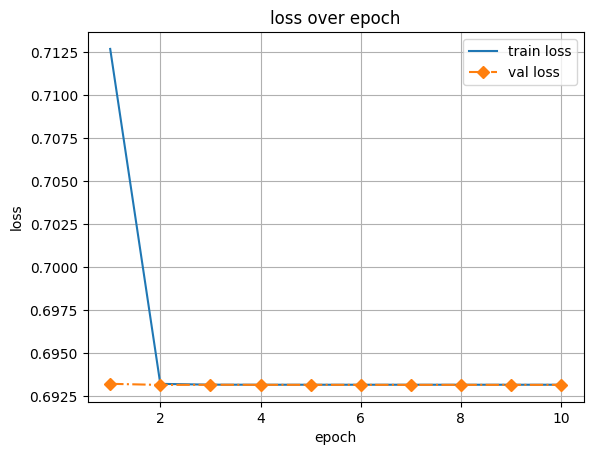

In [27]:
trained_model, best_val_loss = train(model=model.to(device),
          num_epochs=10,
          train_loader=train_loader,
          val_loader=val_loader,
          lr=1e-4,
          weight_decay=1e-5,
          patience=25)